In [56]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn import datasets
from sklearn.linear_model import (LinearRegression, HuberRegressor,
                                  RANSACRegressor, TheilSenRegressor)

In [57]:
def find_fit(edges,**args):
    points = []
    y,x = edges.shape
    it = np.nditer(edges, flags=['multi_index'])
    for p in it:
        if p>0:
            points.append(it.multi_index)
    points = np.array(points)/[y,x]
    X = points[:,1]
    Y = points[:,0]
    alf, b = np.linalg.lstsq(np.vstack([X, np.ones(len(X))]).T, Y, rcond=2)[0]
    std = np.sqrt(np.mean((alf * X + b - Y)**2))
    if args.get('plot') == True:
        plt.plot(X, Y, 'o', label='Original data', markersize=3)
        plt.plot(X, alf * X + b, 'r', label='Fitted line')
        plt.plot(X, alf * X + b + std, 'r', label='Fitted line')
        plt.legend()
        plt.show()
    return alf, b, std


def find_fit2(edges, **args):
    y, x = edges.shape
    num = np.tile(np.linspace(0, 1, y), (x, 1)).T

    edges = edges > 0
    print(edges.max())
    s = np.sum(edges, axis=0)
    m = np.sum(edges * num, axis=0) / s
    st = np.std(edges * num, axis=0)
    std = np.median(st)
    if args.get('plot') == True:
        plt.plot(st, 'o')
        plt.plot([0, x - 1], [std, std])
        plt.show()
    X = np.linspace(0, 1, x)
    bad = np.argwhere(np.isnan(m))
    X = np.delete(X, bad)
    m = np.delete(m, bad)
    X = X.reshape([-1, 1])
    ransac = RANSACRegressor(random_state=42).fit(X, m)
    if args.get('plot') == True:
        pred = ransac.predict(X)
        plt.plot(m, 'o')
        plt.plot(pred)
        plt.plot(pred + std)
        plt.show()
    return float(ransac.estimator_.coef_), float(ransac.predict([[0]])), std


def turn_crop(im, alf, b, std, **args):
    w = args.get('width', 4)
    up = max(b, b + alf)
    down = min(b, b + alf)
    y, x = im.shape
    up = int(np.clip(up + w * std, 0, 1) * y)
    down = int(np.clip(down - w * std, 0, 1) * y)
    cr_im = im[down:up, :]
    y_new = cr_im.shape[0]
    M = cv2.getRotationMatrix2D([x / 2, y_new / 2],
                                np.arctan(alf * y / x) * 180 / np.pi, 1)
    rotated = cv2.warpAffine(cr_im,
                             M, [cr_im.shape[1], cr_im.shape[0]],
                             borderMode=cv2.BORDER_REPLICATE)
    y_min = int(y_new / 2 - w * std * y)
    y_max = int(y_new / 2 + w * std * y)
    rotated = rotated[y_min:y_max]
    if args.get('plot') == True:
        plt.imshow(rotated)
        plt.show()
    return rotated


def cuts(m, n):
    y, x = m.shape
    step = x / n
    b = np.ceil(np.arange(step, x, step)).astype(int)
    lis = np.split(m, b, axis=1)
    means = []
    for l in lis:
        means.append(l.mean(axis=1))
    return np.stack(means)


def fit(m, x):
    ransac = RANSACRegressor(random_state=42).fit(x.reshape([-1, 1]), m)
    pred = ransac.predict(x.reshape([-1, 1]))
    std = np.mean((pred - m)**2)
    return std, {'x': x[[0, -1]], 'y': pred[[0, -1]]}


In [456]:
from scipy.optimize import root_scalar


class window_fit():
    def __init__(self, mas, w):
        self.mas = mas
        self.w = w
        self.x, self.y = mas.shape
        self.v = np.ones_like(mas) * float('-inf')
        self.Y = np.arange(self.y)
        self.boards = np.zeros([self.x, 2])

    def get(self, x, y):
        y -= self.w / 2
        x0 = math.floor(x)
        x1 = math.ceil(x)
        y0 = math.floor(y)
        y1 = math.ceil(y)
        s0 = self.calc(x0, y0)
        s1 = self.calc(x1, y1)
        s = s1 * (y - y0) + s0 * (1 - (y - y0))
        return s

    def calc(self, x, y):
        if self.v[x, y] == float('-inf'):
            s, p = fit(self.mas[x, y:y + self.w], self.Y[y:y + self.w])
            self.v[x, y] = math.log(s)
            return math.log(s)
        else:
            return self.v[x, y]

    def get_betwin(self, y0, y1):
        y0, y1 = min(y0, y1), max(y0, y1)
        y0 = max(0, math.ceil(y0))
        y1 = min(self.y - 1, math.floor(y1))
        return np.arange(y0,y1 + 1)

    def get_mas(self, x):
        X = np.argwhere(self.v[x] != float('-inf'))
        Y = self.v[x, X]
        X = X + self.w / 2
        return X.flatten(), Y.flatten()

    def calc_gerd(self, n):
        Y = np.ceil(np.linspace(0, self.y - self.w - 1, n)).astype(int)
        for x in range(self.x):
            for y in Y:
                self.calc(x, y)

    def find_borders(self, kof):
        for x in range(self.x):
            p, val = self.get_mas(x)
            # plt.plot(p,val)
            # plt.show()
            ma = val.max()
            mi = val.min()
            tr = mi * kof + ma * (1 - kof)
            ind = np.argwhere(val > tr).flatten()
            b = [ind.min() - 1, ind.min()]
            # print(x,b)
            # print(x,p[b])
            y0 = root_scalar(lambda y: self.get(x, y) - tr,
                             method='brentq',
                             bracket=p[b]).root
            b = [ind.max(), ind.max() + 1]
            y1 = root_scalar(lambda y: self.get(x, y) - tr,
                             method='brentq',
                             bracket=p[b]).root
            self.boards[x, :] = [y0 + self.w / 2 - 0.5, y1 - self.w / 2 - 0.5]
a

In [ ]:
im = cv2.imread('data/im40.0.jpg', cv2.IMREAD_GRAYSCALE)
y, x = im.shape
kof = 20
tr = 100
im4 = cv2.resize(im, dsize=(x // kof, y // kof))
edges = cv2.Canny(im4, tr, tr, L2gradient=True)
plt.imshow(edges)
plt.show()
alf, b, std = find_fit2(edges, plot=True)
print(alf, b, std)
rotated = turn_crop(im, alf, b, std, width=1, plot=True)

In [467]:
mas = cuts(rotated, 30)
wf = window_fit(mas,40)
wf.calc_gerd(20)
wf.find_borders(0.5)

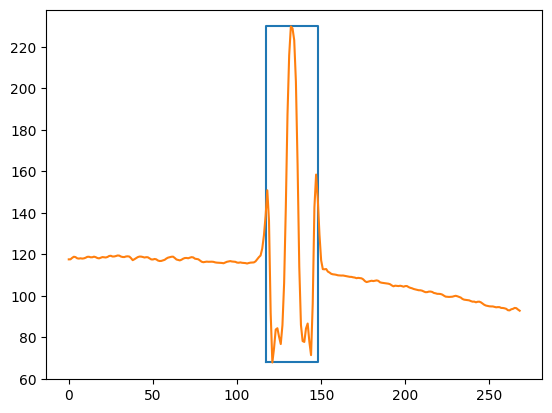

In [468]:
x = 25
y0 = wf.boards[x, 0]
y1 = wf.boards[x, 1]
ins = wf.mas[x, wf.get_betwin(y0, y1)]
ma = ins.max()
mi = ins.min()
vals = [mi, ma, ma, mi, mi]
points = [y0, y0, y1, y1, y0]
plt.plot(points, vals)
plt.plot(wf.Y, wf.mas[x])
plt.show()

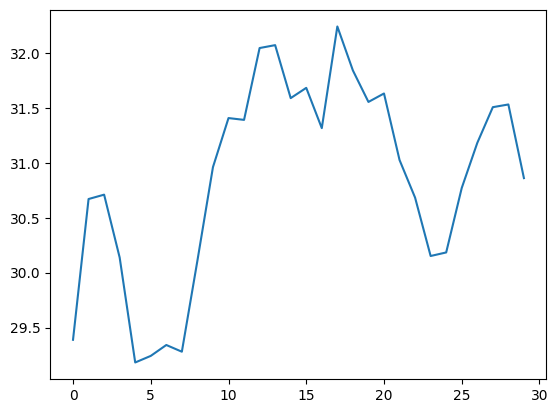

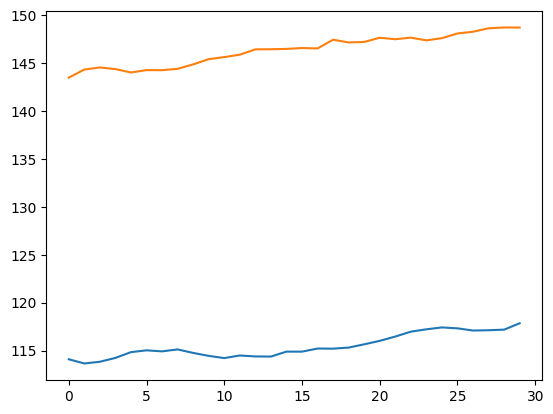

In [470]:
plt.plot(wf.boards[:, 1] - wf.boards[:, 0])
plt.show()
plt.plot(wf.boards)

In [402]:
wf.find_borders(0.5)

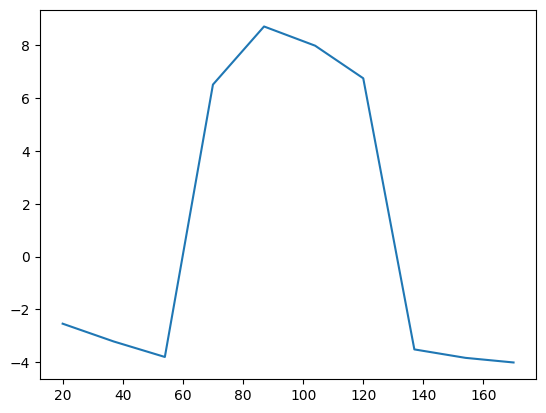

In [389]:
X,Y = wf.get_mas(1)
plt.plot(X,Y)

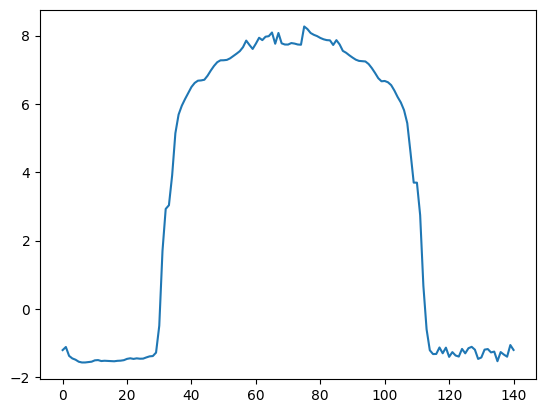

[81, 112]


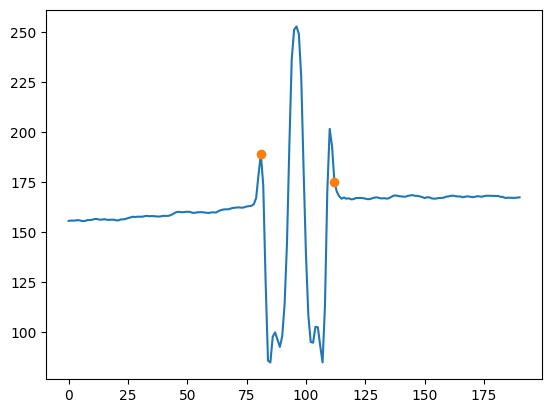

In [256]:
mas = cuts(rotated, 50)
m = mas[10]
# print(m.shape)
x = np.arange(len(m))
start = 10
w = 50
std = []
for start in range(len(m)-w):
    s, p = fit(m[start:start + w], x[start:start + w])
    std.append(s)
std2 = np.log(std)
plt.plot(std2)
plt.show()
lev = (max(std2) + min(std2)) / 2
ind = np.argwhere(std2 > lev).flatten()
b = [min(ind) + w - 3, max(ind) + 2]
print(b)
plt.plot(x, m)
plt.plot(b, m[b], 'o')
plt.show()

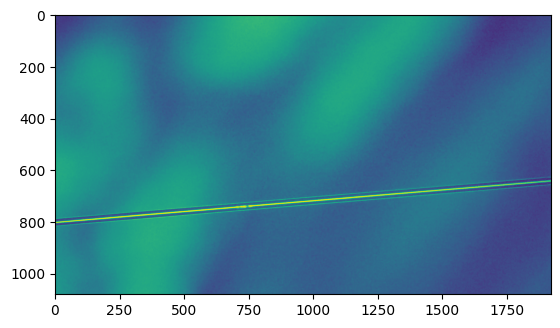

In [439]:
plt.imshow(im)

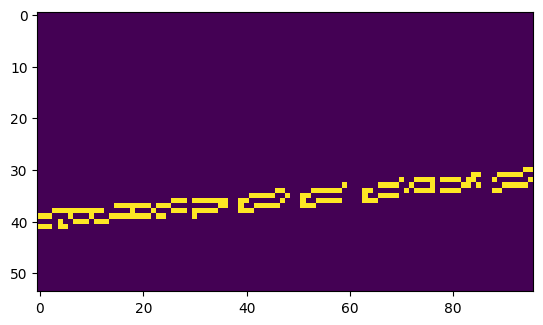

True


/tmp/ipykernel_30147/1712722951.py:8: RuntimeWarning: invalid value encountered in divide
  m = np.sum(edges * num, axis=0) / s


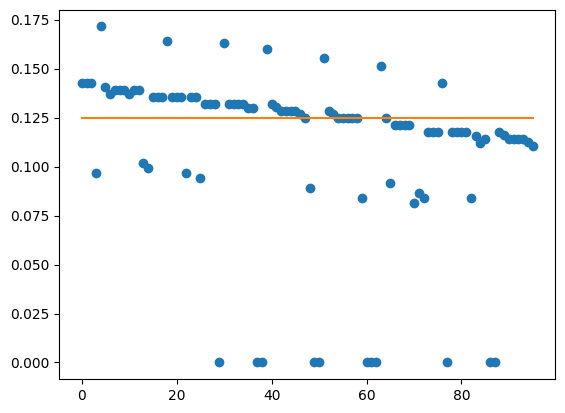

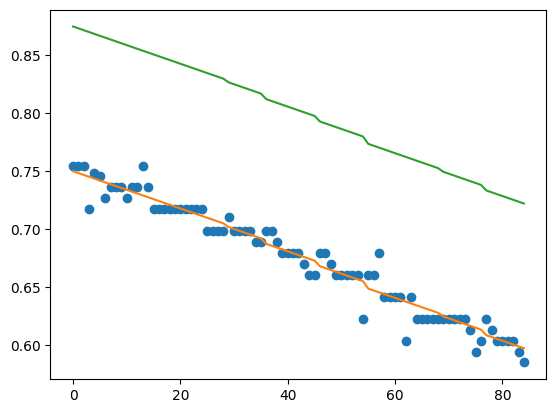

-0.1526390548163112 0.7498300402176222 0.12476681463735105


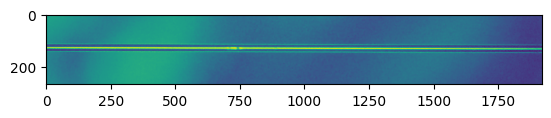

In [466]:
# im = cv2.imread('data/565light.png', cv2.IMREAD_GRAYSCALE)
im = cv2.imread('data/im40.0.jpg', cv2.IMREAD_GRAYSCALE)
y, x = im.shape
kof = 20
tr = 100
im4 = cv2.resize(im, dsize=(x // kof, y // kof))
edges = cv2.Canny(im4, tr, tr, L2gradient=True)
plt.imshow(edges)
plt.show()
alf, b , std = find_fit2(edges, plot=True)
print(alf, b, std)
rotated = turn_crop(im, alf, b, std, width=1, plot=True)

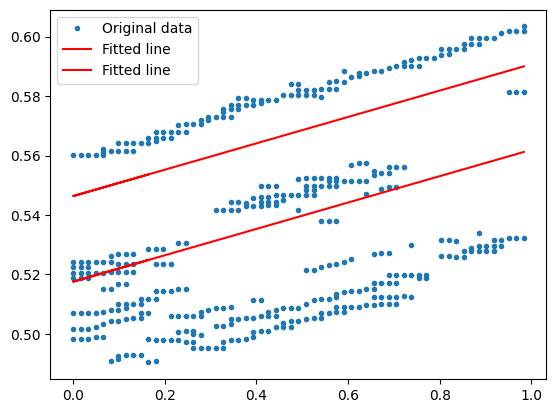

In [85]:
y, x = rotated.shape
rotated2 = cv2.resize(rotated, (x // kof2, y))
gY = cv2.Sobel(rotated2, ddepth=cv2.CV_16SC1, dx=0, dy=1, ksize=3)
gY = cv2.blur(gY,(4,1))
edges = cv2.Canny(dy=gY, dx=gY * 0, threshold1=30, threshold2=30, L2gradient=True)
alf, b, std = find_fit(edges, plot=True)


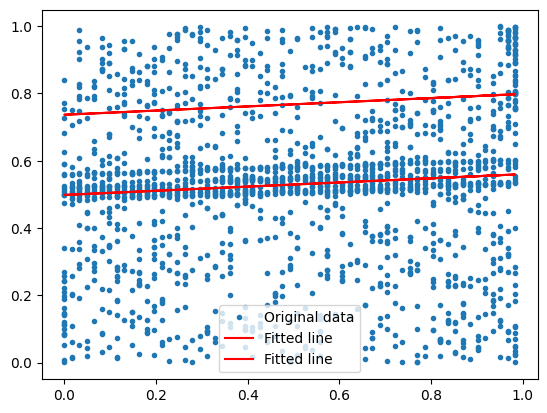

In [65]:
alf, b, std = find_fit(edges, plot=True)

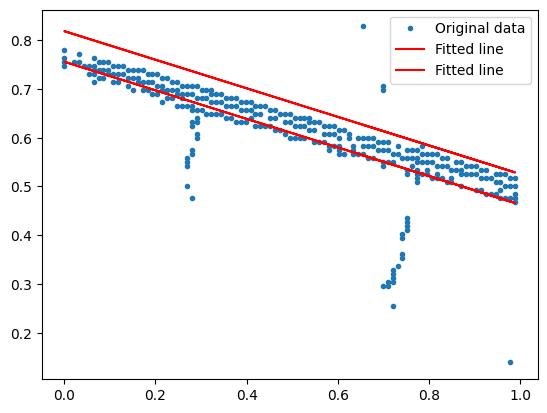

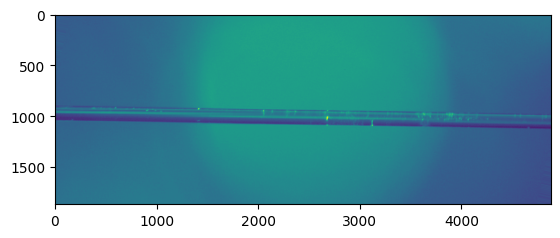

In [57]:
im = cv2.imread('data/565light.png', cv2.IMREAD_GRAYSCALE)
y, x = im.shape
kof = 40
im4 = cv2.resize(im, dsize=(y // kof, x // kof))
edges = cv2.Canny(im4, 60, 60, L2gradient=True)
alf, b, std = find_fit(edges, plot=True)
rotated = turn_crop(im, alf, b, std, w=4,plot=True)

kof2 = 80
y, x = rotated.shape
rotated2 = cv2.resize(rotated, (x // kof2, y))
gY = cv2.Sobel(rotated2, ddepth=cv2.CV_16SC1, dx=0, dy=1, ksize=3)
gY = cv2.blur(gY, (4, 1))
edges = cv2.Canny(dy=gY,
                  dx=gY * 0,
                  threshold1=30,
                  threshold2=30,
                  L2gradient=True)
alf, b, std = find_fit(edges, plot=True)


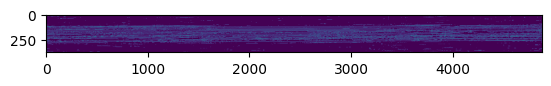

In [312]:
edges = cv2.Canny(cv2.blur(rotated2, (200, 1)), 5, 5, L2gradient=True)
plt.imshow(edges)

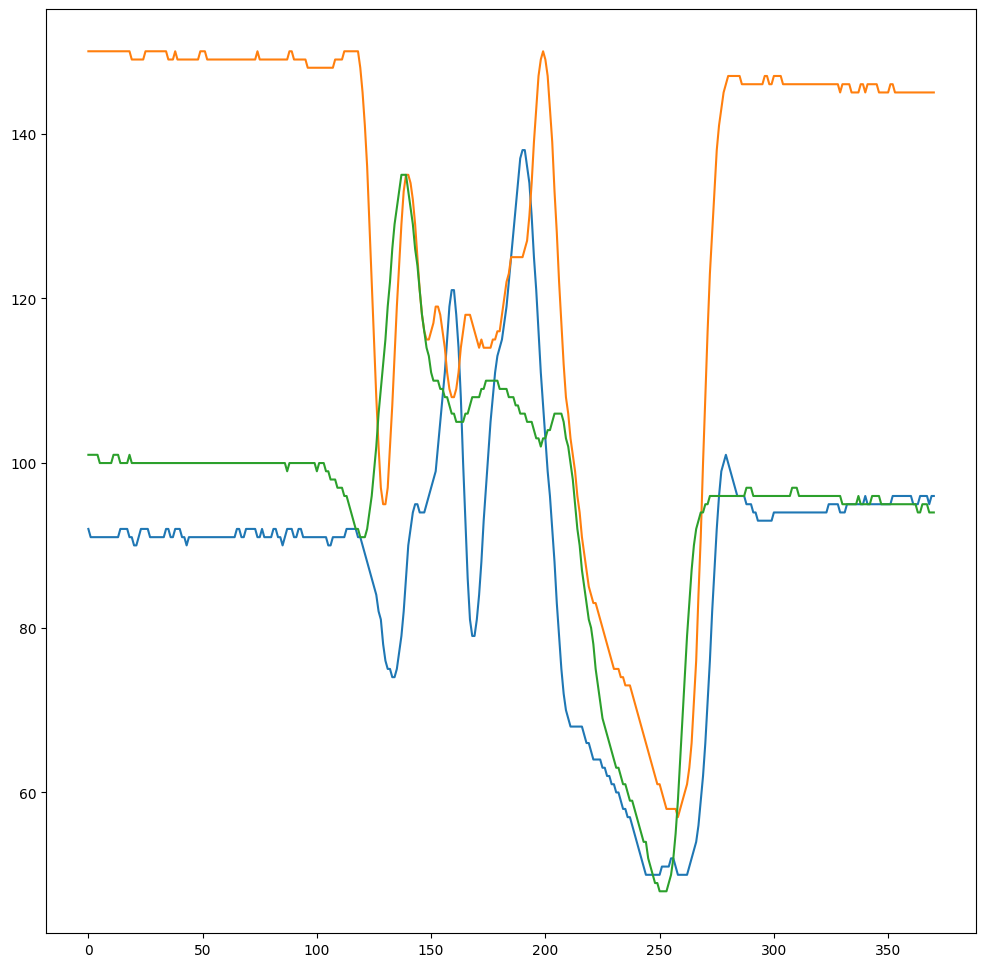

In [299]:
plt.figure(figsize=(12, 12))
plt.plot(cv2.blur(rotated2,(500,1))[:,range(0,5000,2000)])

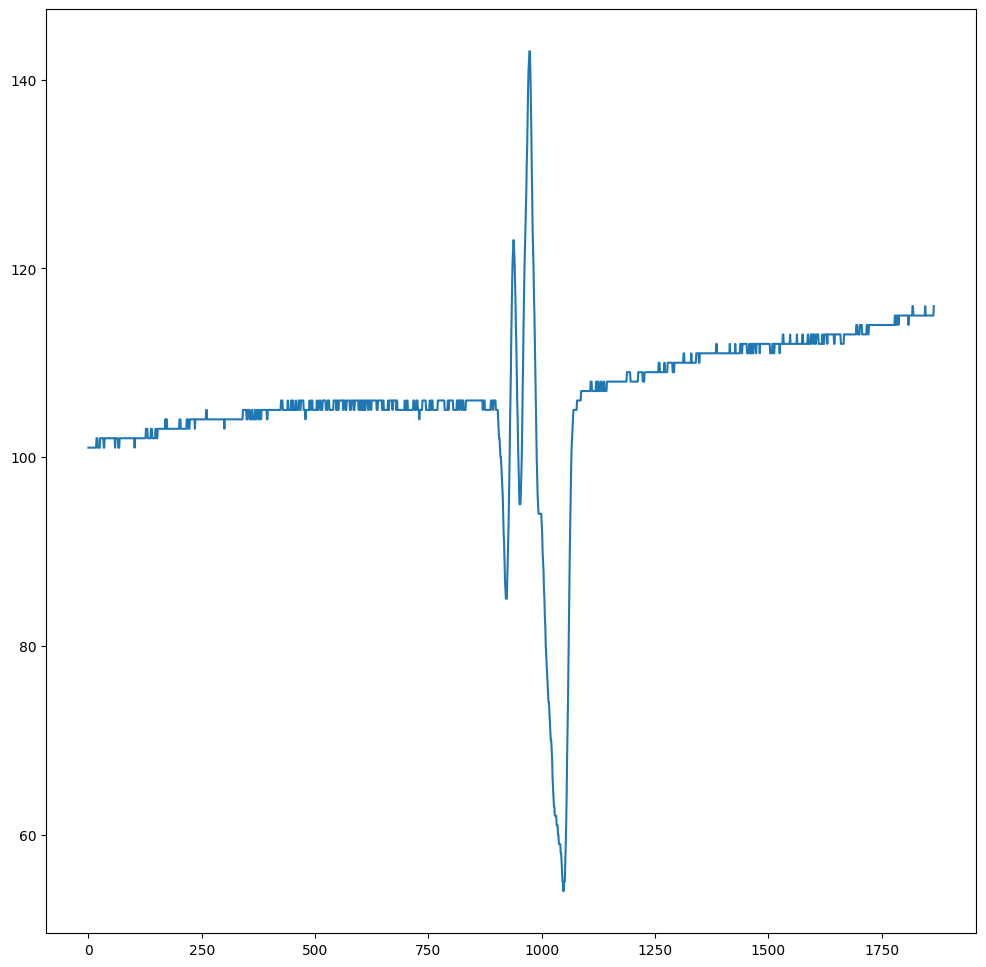

In [297]:
plt.figure(figsize=(12, 12))
plt.plot(cv2.blur(rotated, (500, 1))[:, 1000])


In [ ]:
def window_std(data,w,treshhold):
    l = len(data)
    x0 = w//2
    x1 = l - w//2 - 1
    err=[]
    for x in range(x0,x1):
        win = data[x-w//2,x+w//2]
        

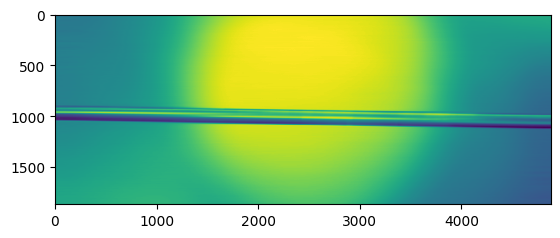

In [293]:
plt.imshow(cv2.blur(rotated,(500,1)))

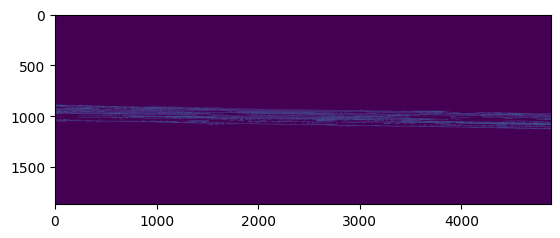

In [237]:
from matplotlib.pyplot import colorbar


edges = cv2.Canny(cv2.blur(rotated, (200, 1)), 10, 10, L2gradient=True)
plt.imshow(edges,vmin=0,vmax=255)

In [229]:
edges.min()

0